<a href="https://colab.research.google.com/github/kishore862022/Codsoft_Task-1/blob/main/CODSOFT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CREDIT CARD FRAUD DETECTION**

In [ ]:
!pip install category_encoders
!pip install boruta
!pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
#Basic libraries
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

#Sampling methods
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

#feature engineering
import datetime as dt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler

#Feature Selection
from boruta import BorutaPy

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

#Hyperparameter tuning
from skopt import gp_minimize

#Model evaluation
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn import metrics
import scipy.stats as stats
from scipy.stats import skew

Importing Data

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/fraudTest.csv", index_col=0)
pd.options.display.float_format = '{:,.2f}'.format

Data Cleansing

In [ ]:
train.head(3)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.97,-80.94,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.99,-81.20,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.32,-110.44,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.45,-109.96,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.67,-73.54,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.50,-74.20,0


In [ ]:
train.shape

(555719, 22)

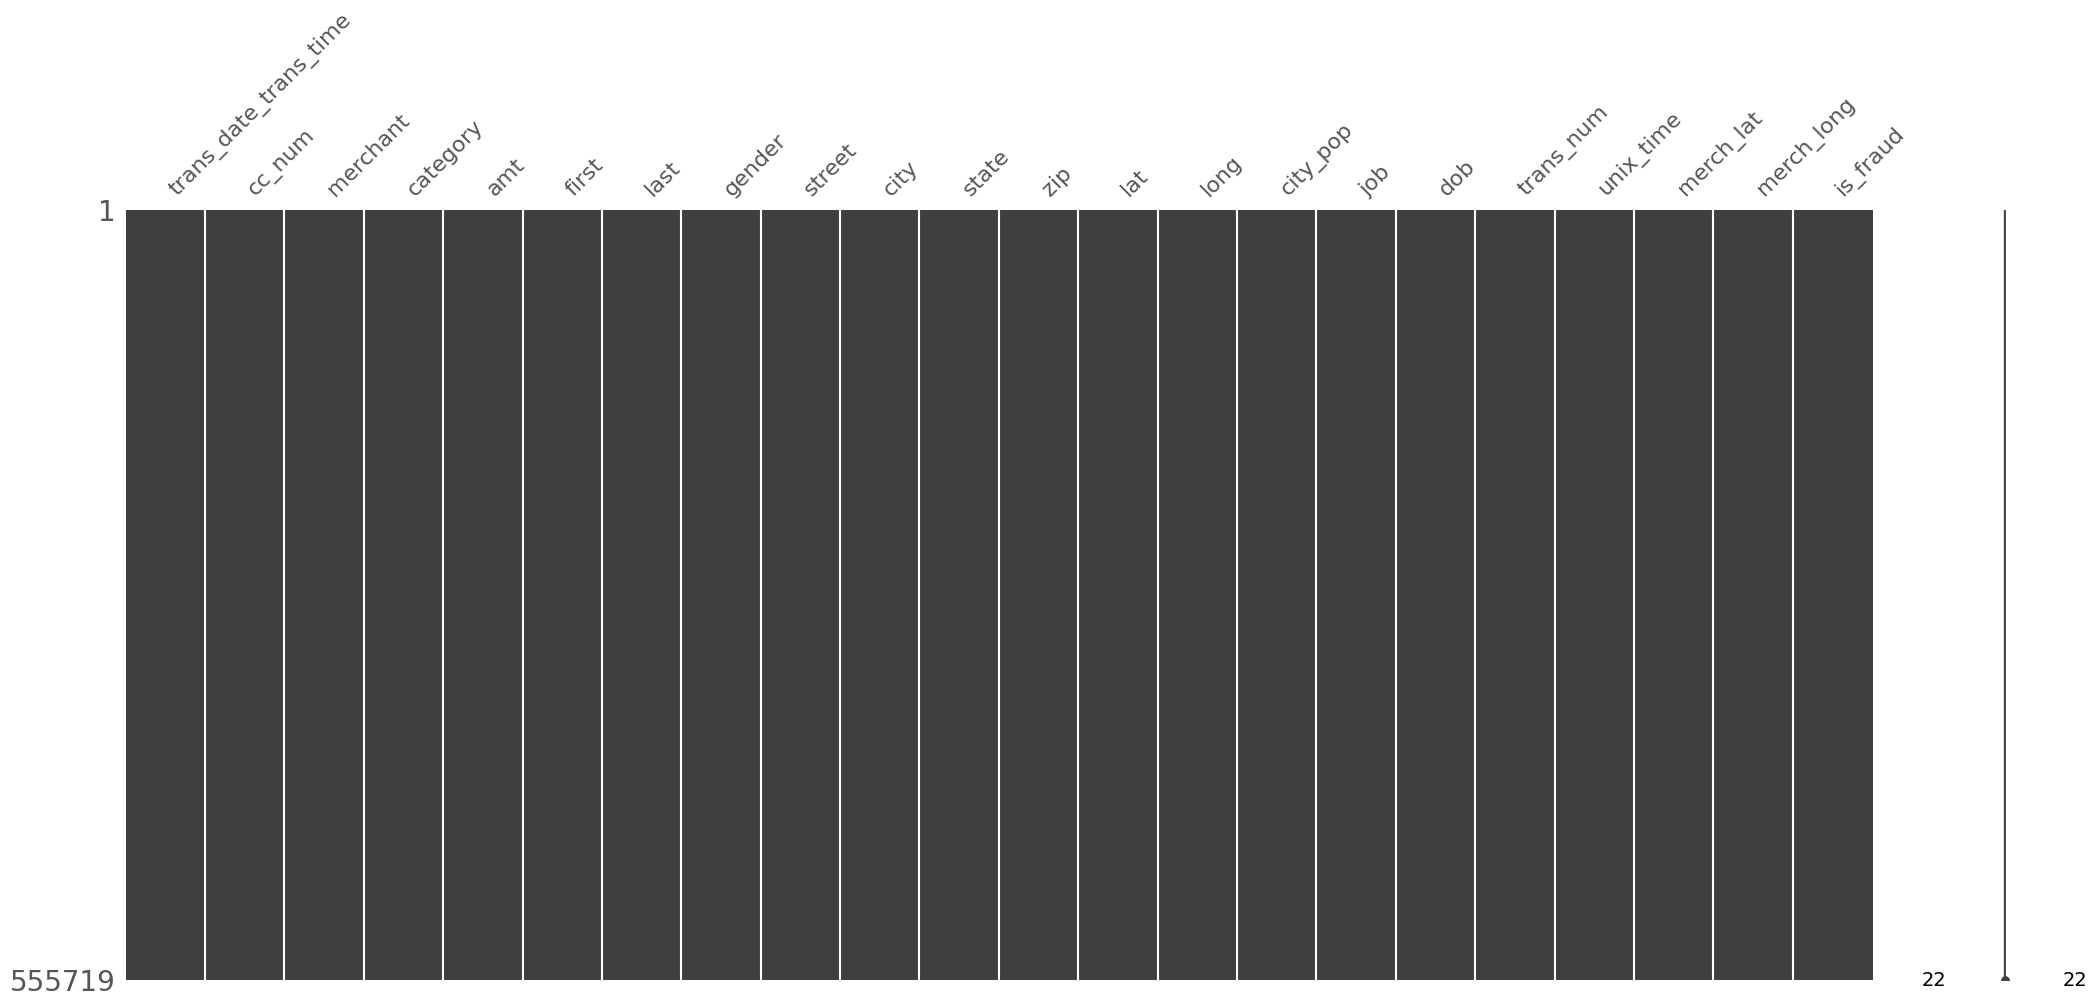

In [ ]:
msno.matrix(train);

In [ ]:
train.isna().sum()


trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Exploratory Data Analysis (EDA)

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
cc_num,"555,719.00","417,838,695,528,764,096.00","1,309,836,622,980,612,608.00","60,416,207,185.00","180,042,946,491,150.00","3,521,417,320,836,166.00","4,635,330,563,105,903.00","4,992,346,398,065,154,048.00"
amt,"555,719.00",69.39,156.75,1.00,9.63,47.29,83.01,"22,768.11"
zip,"555,719.00","48,842.63","26,855.28","1,257.00","26,292.00","48,174.00","72,011.00","99,921.00"
lat,"555,719.00",38.54,5.06,20.03,34.67,39.37,41.89,65.69
long,"555,719.00",-90.23,13.72,-165.67,-96.80,-87.48,-80.18,-67.95
city_pop,"555,719.00","88,221.89","300,390.89",23.00,741.00,"2,408.00","19,685.00","2,906,700.00"
unix_time,"555,719.00","1,380,678,865.17","5,201,104.07","1,371,816,865.00","1,376,028,627.50","1,380,761,988.00","1,385,866,984.00","1,388,534,374.00"
merch_lat,"555,719.00",38.54,5.10,19.03,34.76,39.38,41.95,66.68
merch_long,"555,719.00",-90.23,13.73,-166.67,-96.91,-87.45,-80.26,-66.95
is_fraud,"555,719.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00


In [ ]:
train["amt"].describe()

count   555,719.00
mean         69.39
std         156.75
min           1.00
25%           9.63
50%          47.29
75%          83.01
max      22,768.11
Name: amt, dtype: float64

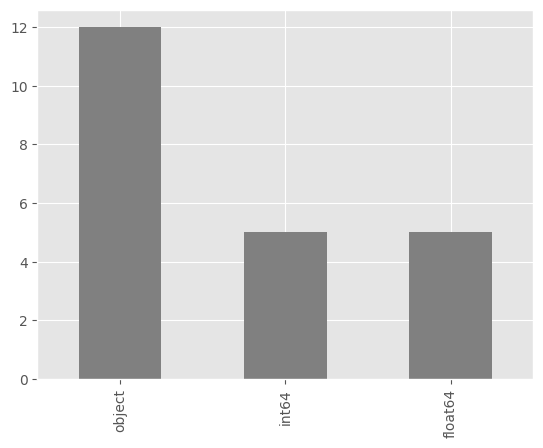

In [ ]:
train.dtypes.value_counts().plot(kind='bar', color="grey");

Univariate analysis

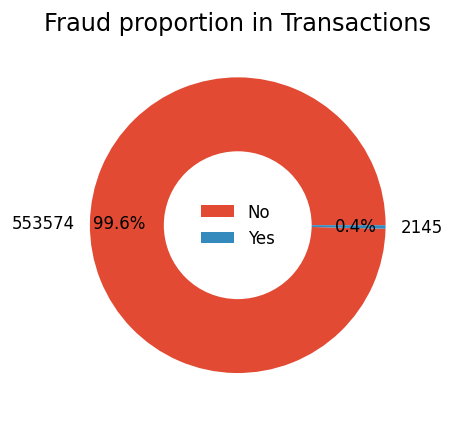

In [ ]:
donut = train["is_fraud"].value_counts().reset_index()

labels = ["No", "Yes"]
explode = (0, 0)

fig, ax = plt.subplots(dpi=120, figsize=(8, 4))
plt.pie(donut["is_fraud"],
        labels=donut["is_fraud"],
        autopct="%1.1f%%",
        pctdistance=0.8,
        explode=explode)

centre_circle = plt.Circle((0.0, 0.0), 0.5, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Fraud proportion in Transactions")
plt.legend(labels, loc="center", frameon=False)
plt.show();

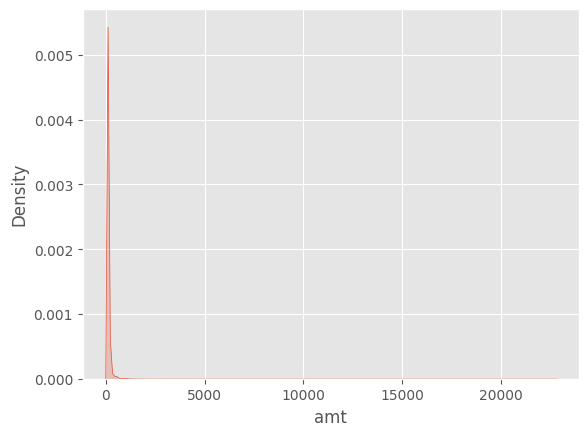

In [ ]:
sns.kdeplot(train["amt"], fill=True);

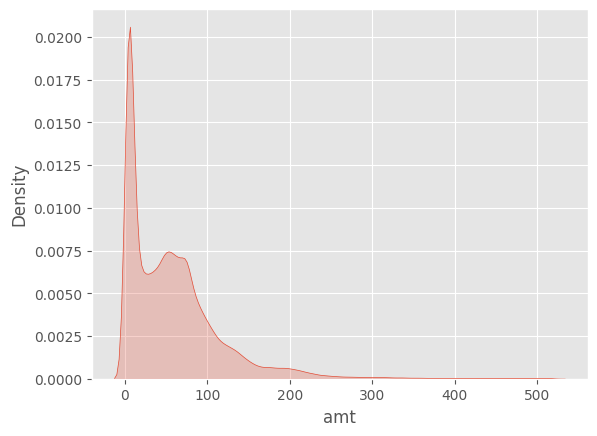

In [ ]:
p99 = train["amt"].quantile(0.99)
sns.kdeplot(x="amt", data=train[train["amt"] <= p99], fill=True);

Multivariate analysis

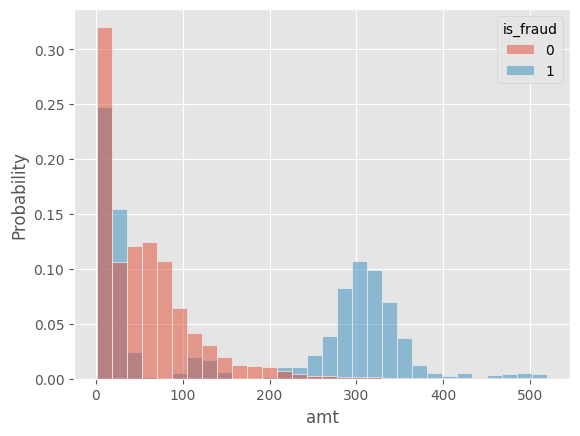

In [ ]:
p99 = train["amt"].quantile(0.99)
sns.histplot(x="amt", hue="is_fraud", bins=30,
             stat="probability", data=train[train["amt"] <= p99],
             common_norm=False);

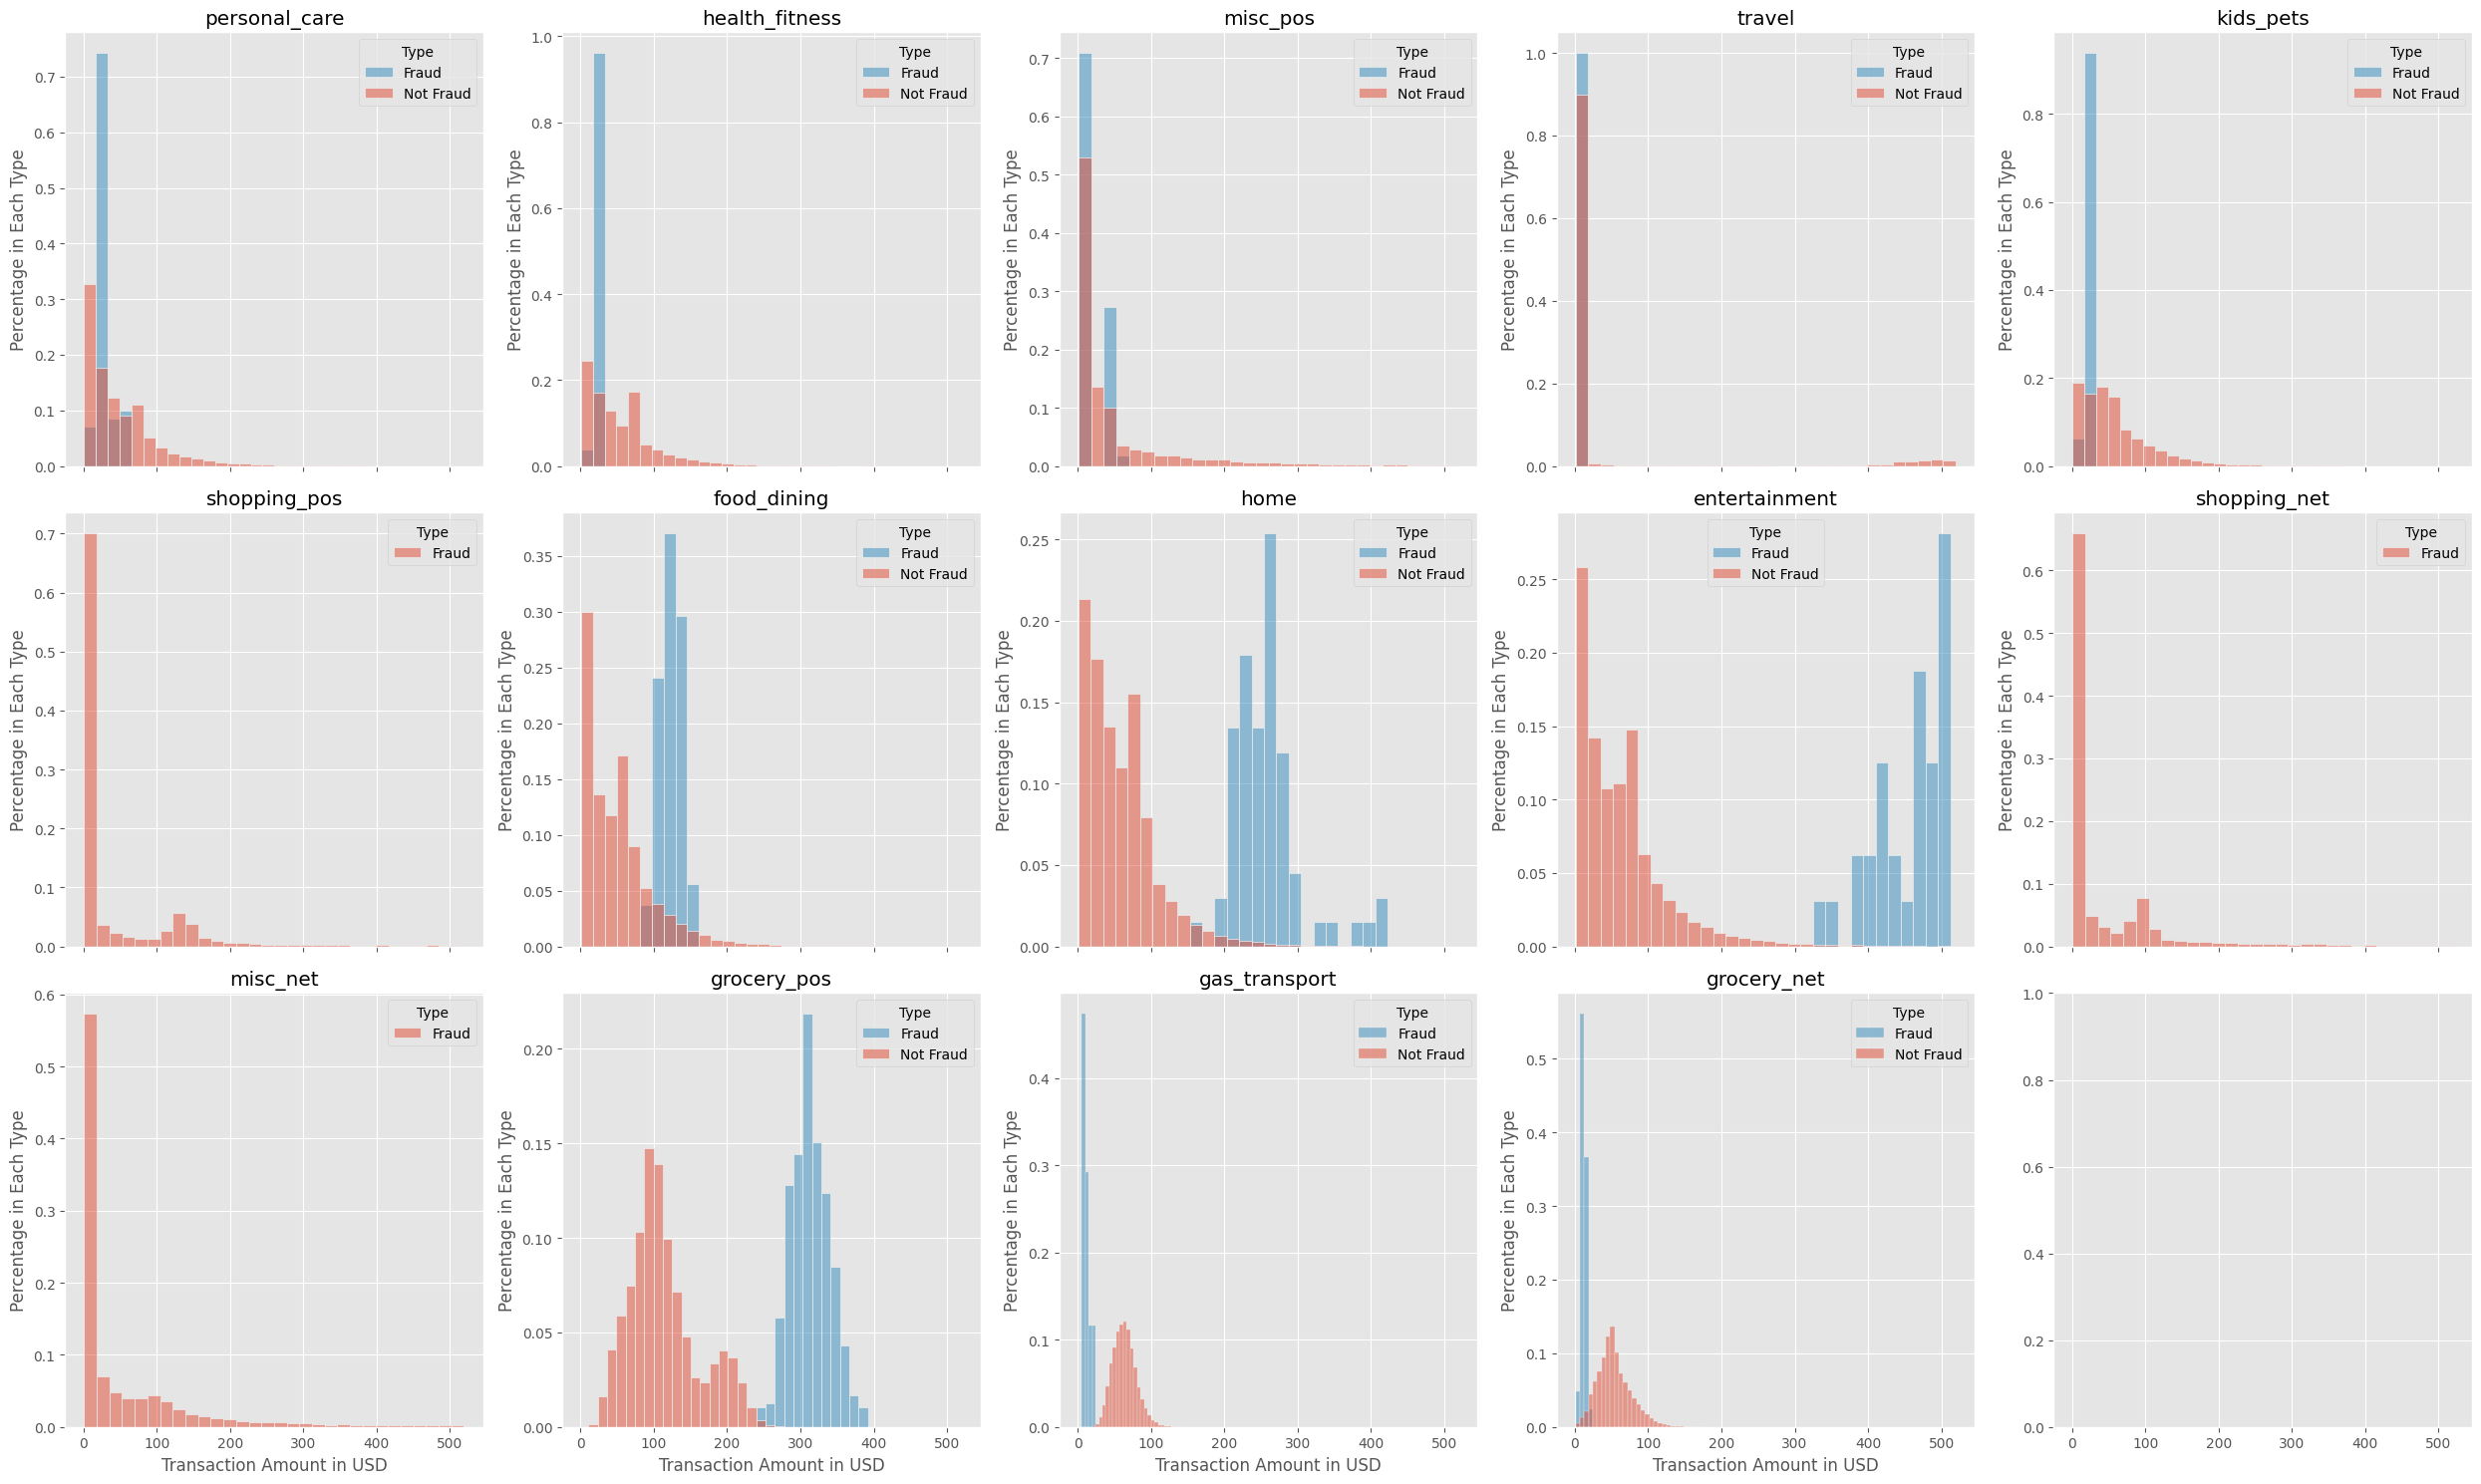

In [ ]:
categories = train['category'].unique()

num_plots = len(categories)
num_rows = math.isqrt(num_plots)
num_cols = math.ceil(num_plots / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(
    5*num_cols, 5*num_rows), sharex=True)

for i, category in enumerate(categories):

    row = i // num_cols
    col = i % num_cols

    data_category = train[train['category'] == category]

    if num_rows == 1 and num_cols == 1:
        ax = axes
    elif num_rows == 1 or num_cols == 1:
        ax = axes[i]
    else:
        ax = axes[row, col]

    sns.histplot(x='amt', data=data_category[data_category['amt'] <= p99],
                 hue='is_fraud', stat='probability',
                 common_norm=False, bins=30, ax=ax)

    ax.set_ylabel('Percentage in Each Type')
    ax.set_xlabel('Transaction Amount in USD')
    ax.set_title(f'{category}')
    ax.legend(title='Type', labels=['Fraud', 'Not Fraud'])

plt.tight_layout()

plt.show();

In [ ]:
# non_fraud
non_fraud = train[train['is_fraud'] == 0]['category'].value_counts(
    normalize=True).to_frame().reset_index()
non_fraud.columns = ['category', 'not_fraud_percentual_vs_total']

# fraud
fraud = train[train['is_fraud'] == 1]['category'].value_counts(
    normalize=True).to_frame().reset_index()
fraud.columns = ['category', 'fraud_percentage_vs_total']

# merging two dataframes and calculating "fraud level"
non_fraud_vs_fraud = non_fraud.merge(fraud, on='category')
non_fraud_vs_fraud['fraud_level'] = non_fraud_vs_fraud['fraud_percentage_vs_total'] - \
    non_fraud_vs_fraud['not_fraud_percentual_vs_total']

non_fraud_vs_fraud

,category,not_fraud_percentual_vs_total,fraud_percentage_vs_total,fraud_level
0,gas_transport,0.10,0.07,-0.03
1,home,0.09,0.03,-0.06
2,grocery_pos,0.09,0.23,0.13
3,shopping_pos,0.09,0.10,0.01
4,kids_pets,0.09,0.03,-0.06
5,shopping_net,0.07,0.24,0.16
6,entertainment,0.07,0.03,-0.04
7,personal_care,0.07,0.03,-0.04
8,food_dining,0.07,0.03,-0.05
9,health_fitness,0.07,0.02,-0.04


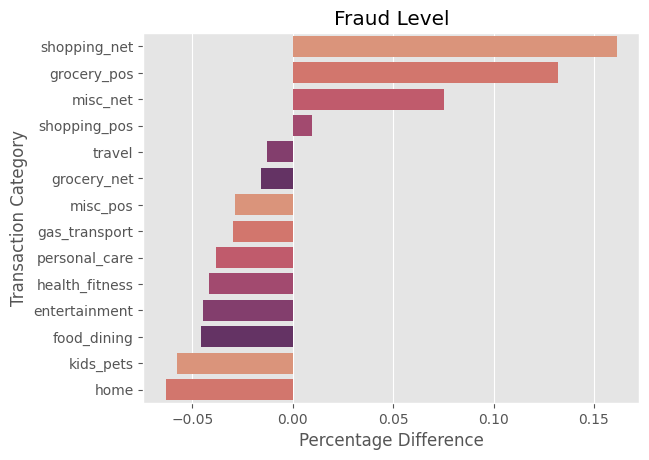

In [ ]:
custom_palette = sns.color_palette("flare")
ax = sns.barplot(y='category', x='fraud_level',
                 data=non_fraud_vs_fraud.sort_values('fraud_level', ascending=False), palette=custom_palette)
ax.set_xlabel('Percentage Difference')
ax.set_ylabel('Transaction Category')
plt.title('Fraud Level');

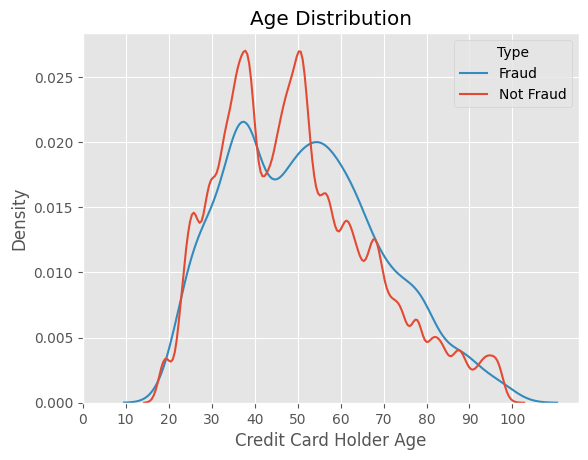

In [ ]:
train['age'] = dt.date.today().year-pd.to_datetime(train['dob']).dt.year
ax = sns.kdeplot(x='age', data=train, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0, 110, 10))
plt.title('Age Distribution')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud']);

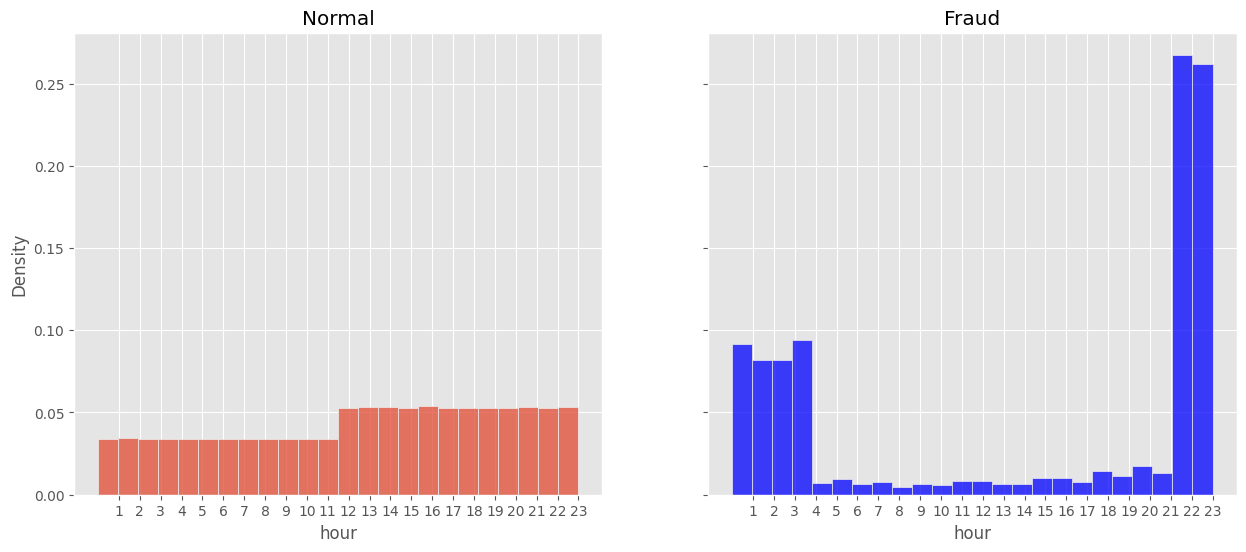

In [ ]:
train['hour'] = pd.to_datetime(train['trans_date_trans_time']).dt.hour
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='hour', data=train[train["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1)
ax2 = sns.histplot(x='hour', data=train[train["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 24))
ax2.set_xticks(np.arange(1, 24));

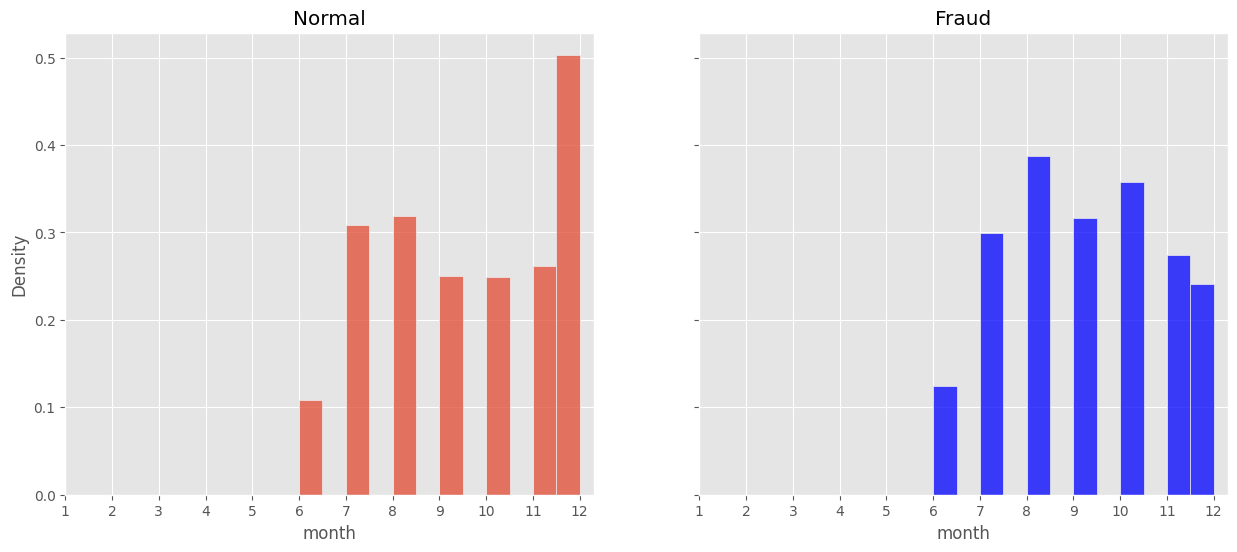

In [ ]:
train['month'] = pd.to_datetime(train['trans_date_trans_time']).dt.month
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
ax1 = sns.histplot(x='month', data=train[train["is_fraud"] == 0],
                   stat="density", bins=12, ax=ax1)
ax2 = sns.histplot(x='month', data=train[train["is_fraud"] == 1],
                   stat="density", bins=12, ax=ax2, color="blue")
ax1.set_title("Normal")
ax2.set_title("Fraud")
ax1.set_xticks(np.arange(1, 13))
ax2.set_xticks(np.arange(1, 13));

In [ ]:
train.drop(columns=["merchant", "first", "last", "street",
           "unix_time", "trans_num"], inplace=True)

In [ ]:
train.head(2)

,trans_date_trans_time,cc_num,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,age,hour,month
0,2020-06-21 12:14:25,2291163933867244,personal_care,2.86,M,Columbia,SC,29209,33.97,-80.94,333497,Mechanical engineer,1968-03-19,33.99,-81.20,0,55,12,6
1,2020-06-21 12:14:33,3573030041201292,personal_care,29.84,F,Altonah,UT,84002,40.32,-110.44,302,"Sales professional, IT",1990-01-17,39.45,-109.96,0,33,12,6


Scaling

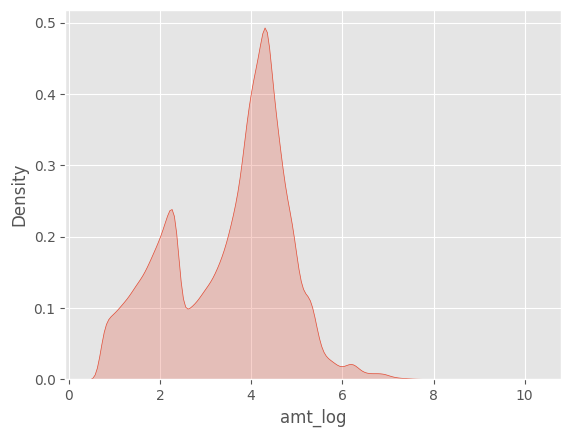

In [ ]:
train["amt_log"] = np.log1p(train["amt"])
sns.kdeplot(train["amt_log"], fill=True);

In [ ]:
def check_normality(feature):
    plt.figure(figsize=(8, 8))
    ax1 = plt.subplot(1, 1, 1)
    stats.probplot(train[feature], dist=stats.norm, plot=ax1)
    ax1.set_title(f'{feature} Q-Q plot', fontsize=20)
    sns.despine()

    mean = train[feature].mean()
    std = train[feature].std()
    skew = train[feature].skew()
    print(f'{feature} : mean: {mean:.2f}, std: {std:.2f}, skew: {skew:.2f}')

amt : mean: 69.39, std: 156.75, skew: 37.13


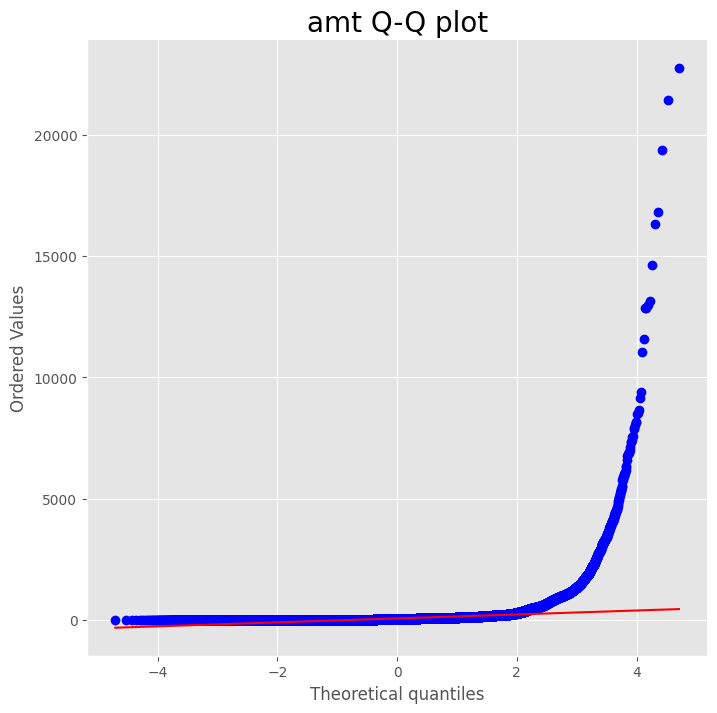

In [ ]:
check_normality("amt");

amt_log : mean: 3.53, std: 1.29, skew: -0.31


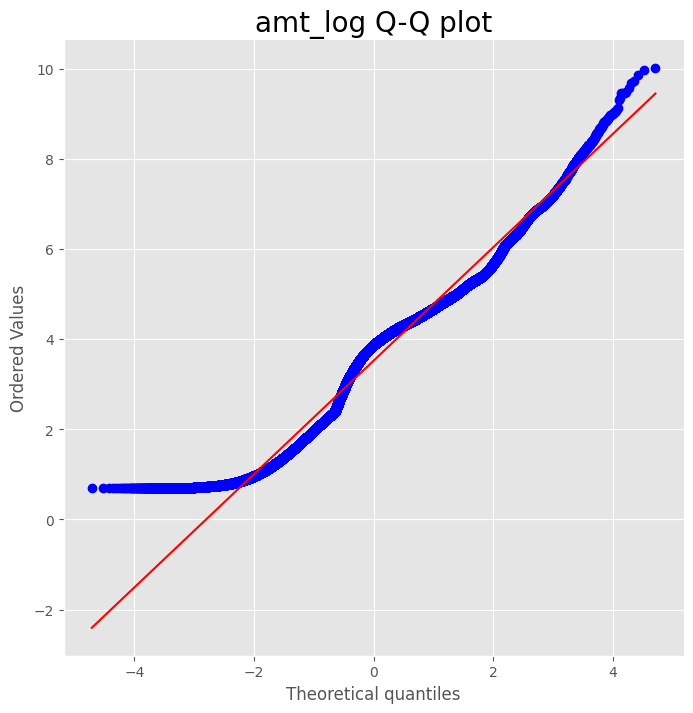

In [ ]:
check_normality("amt_log");